In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc

import pickle

coord.galactocentric_frame_defaults.set('v4.0')

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

In [2]:
plt.style.use('notebook')

## Define coordinate system

In [3]:
tc = Table.read('../data/stream_endpoints_5d.fits')

In [4]:
tc

name,ra [2],dec [2],dec_err [2],d [2],d_err [2],pmra [2],pmdec [2],pm_err [2]
,deg,deg,deg,kpc,kpc,mas / yr,mas / yr,mas / yr
bytes11,float64,float64,float64,float64,float64,float64,float64,float64
ATLAS,9.3 .. 30.7,-20.9 .. -33.2,0.24 .. 0.24,22.9 .. 22.9,4.58 .. 4.58,-0.1 .. -0.1,-1.0 .. -1.0,1.0 .. 1.0
Aliqa Uma,31.7 .. 40.6,-31.5 .. -38.3,0.26 .. 0.26,28.8 .. 28.8,5.76 .. 5.76,0.3 .. 0.3,-0.6 .. -0.6,1.0 .. 1.0
Chenab,-40.7 .. -28.3,-59.9 .. -43.0,0.71 .. 0.71,39.8 .. 39.8,7.96 .. 7.96,0.3 .. 0.3,-2.4 .. -2.4,1.0 .. 1.0
Elqui,10.7 .. 20.6,-36.9 .. -42.4,0.54 .. 0.54,50.1 .. 50.1,10.02 .. 10.02,0.1 .. 0.1,-0.4 .. -0.4,1.0 .. 1.0
Fimbulthul,198.74 .. 214.23,-29.56 .. -22.76,0.5 .. 0.5,4.22 .. 4.22,0.01 .. 0.01,-8.2 .. -18.9,-8.1 .. -12.8,1.0 .. 1.0
"Fj\""{o}rm",197.37 .. 250.88,5.55 .. 64.2,0.5 .. 0.5,4.9 .. 4.9,0.07 .. 0.07,-2.5 .. 2.2,4.0 .. 5.2,1.0 .. 1.0
"Gj\""{o}ll",70.16 .. 90.05,-2.46 .. -20.15,0.5 .. 0.5,3.38 .. 3.38,0.1 .. 0.1,21.7 .. 24.1,-22.1 .. -22.4,1.0 .. 1.0
Indus,-36.3 .. -8.0,-50.7 .. -64.8,0.83 .. 0.83,16.6 .. 16.6,3.32 .. 3.32,3.5 .. 3.5,-5.4 .. -5.4,1.0 .. 1.0


In [5]:
ind = tc['name']=='Elqui'
t_ = tc[ind]

In [6]:
t_

name,ra [2],dec [2],dec_err [2],d [2],d_err [2],pmra [2],pmdec [2],pm_err [2]
,deg,deg,deg,kpc,kpc,mas / yr,mas / yr,mas / yr
bytes11,float64,float64,float64,float64,float64,float64,float64,float64
Elqui,10.7 .. 20.6,-36.9 .. -42.4,0.54 .. 0.54,50.1 .. 50.1,10.02 .. 10.02,0.1 .. 0.1,-0.4 .. -0.4,1.0 .. 1.0


In [7]:
cp = coord.SkyCoord(ra=t_['ra'], dec=t_['dec'], distance=t_['d'], frame='icrs')[0]

In [8]:
pole = gc.pole_from_endpoints(cp[0], cp[1])

In [14]:
fr = gc.GreatCircleICRSFrame(pole=pole, rotation=-35.*u.deg)
cpole = cp.transform_to(fr)
np.min(cpole.phi1), np.max(cpole.phi1)

(<Angle -4.90848156 deg>, <Angle 4.48076849 deg>)

## Create $Gaia$ query

In [15]:
corners = np.array([[-10, -10], [-10,10], [10,10], [10,-10]])

In [16]:
c_corner = coord.SkyCoord(phi1=corners[:,0]*u.deg, phi2=corners[:,1]*u.deg, frame=fr)
ceq_corner = c_corner.transform_to(coord.ICRS)

In [17]:
q_base ='''SELECT * FROM gaiaedr3.gaia_source
WHERE parallax < 1 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       {0.ra.degree}, {0.dec.degree}, 
                       {1.ra.degree}, {1.dec.degree}, 
                       {2.ra.degree}, {2.dec.degree}, 
                       {3.ra.degree}, {3.dec.degree})) = 1
'''

In [18]:
print(q_base.format(ceq_corner[3], ceq_corner[2], ceq_corner[1], ceq_corner[0]))

SELECT * FROM gaiaedr3.gaia_source
WHERE parallax < 1 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       19.276778298075875, -53.774650170372084, 
                       33.00056394029378, -36.19686757116499, 
                       13.314511549645692, -25.91305990969629, 
                       357.1774061439303, -40.77908258081056)) = 1



## Analyze Gaia data

In [19]:
t = Table(fits.getdata('../data/gaia/elqui.fits.gz'))

In [20]:
ceq_nc = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, distance=np.ones(len(t))*t_['d'][:,0]*u.kpc,
                  pm_ra_cosdec=t['pmra']*u.mas/u.yr, pm_dec=t['pmdec']*u.mas/u.yr,
                  radial_velocity=np.zeros(len(t))*u.km/u.s, frame='icrs')
ceq = gc.reflex_correct(ceq_nc)
c_gal = ceq.transform_to(coord.Galactic)

c = ceq.transform_to(fr)

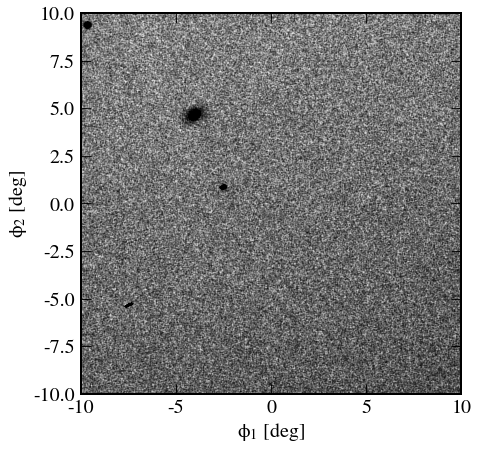

In [24]:
plt.figure(figsize=(15,7))
plt.plot(c.phi1, c.phi2, 'k.', ms=1, alpha=0.1)
# plt.plot(c_gc.phi1, c_gc.phi2, 'ro')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.gca().set_aspect('equal')

In [25]:
ind_phi2 = (np.abs(c.phi2)<2*u.deg) & (np.abs(c.phi1)<5*u.deg)
ind_off = (np.abs(c.phi2)<5*u.deg) & (np.abs(c.phi2)>3*u.deg) & (np.abs(c.phi1)<5*u.deg)
ind_pmeq = (t['pmra']>-0.5) & (t['pmra']<0.5) & (t['pmdec']>-1) & (t['pmdec']<0.5)

In [26]:
points = np.array([t['bp_rp'], t['phot_g_mean_mag']]).T

In [27]:
# distance modulus
distance_app = 50.1*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

iso_full = Table.read('/home/ana/data/isochrones/gaia/mist_13.0_-2.00.cmd',
                 format='ascii.commented_header', header_start=12)
phasecut = (iso_full['phase']>=0) & (iso_full['phase']<4)
iso = iso_full[phasecut]
i_bprp_ = iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3'] + 0.07
i_g_ = iso['Gaia_G_EDR3']+dm

phasecut = (iso_full['phase']>=0) & (iso_full['phase']<3)
iso = iso_full[phasecut]


# main sequence + rgb
i_bprp = iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3'] + 0.07
i_g = iso['Gaia_G_EDR3']+dm

In [28]:
i_left = i_bprp - 0.15*(i_g/28)**2
i_right = i_bprp + 0.2*(i_g/28)**2

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21) & (poly[:,1]>12)
poly_main = poly[ind]

path_main = mpl.path.Path(poly_main)
ind_cmd = path_main.contains_points(points)

In [31]:
g_min = 18.5
g_max = 19.5
bprp_min = -0.1
bprp_max = 0.4
poly_bhb = np.array([[bprp_min, g_max], [bprp_min, g_min], [bprp_max, g_min], [bprp_max, g_max]])
path_bhb = mpl.path.Path(poly_bhb)
ind_bhb = path_bhb.contains_points(points)

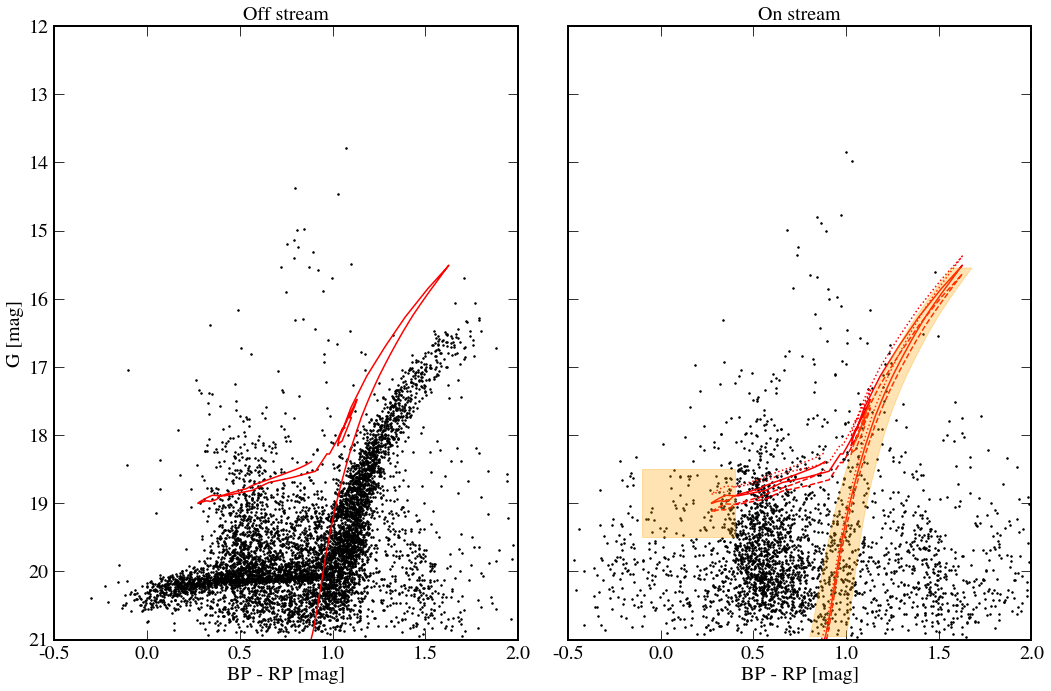

In [32]:
fig, ax = plt.subplots(1,2,figsize=(15,10), sharex=True, sharey=True)

plt.sca(ax[0])
plt.plot(t['bp_rp'][ind_off & ind_pmeq], t['phot_g_mean_mag'][ind_off & ind_pmeq], 'k.', ms=3, alpha=1)
plt.plot(i_bprp_, i_g_, 'r-')

plt.xlabel('BP - RP [mag]')
plt.ylabel('G [mag]')
plt.title('Off stream', fontsize='medium')
plt.xlim(-0.5,2)
plt.ylim(21,12)

plt.sca(ax[1])
plt.plot(t['bp_rp'][ind_phi2 & ind_pmeq], t['phot_g_mean_mag'][ind_phi2 & ind_pmeq], 'k.', ms=3, alpha=1)
plt.plot(i_bprp_, i_g_, 'r-')

# distance uncertainty
delta_distance = 3*u.kpc
dm_plus = 5*np.log10(((distance_app+delta_distance).to(u.pc)).value) - 5*np.log10((distance_app.to(u.pc)).value)
dm_minus = 5*np.log10((distance_app.to(u.pc)).value) - 5*np.log10(((distance_app-delta_distance).to(u.pc)).value)
plt.plot(i_bprp_, i_g_+dm_plus, 'r--')
plt.plot(i_bprp_, i_g_-dm_minus, 'r:')


pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

pm = mpl.patches.Polygon(poly_bhb, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

plt.xlabel('BP - RP [mag]')
plt.title('On stream', fontsize='medium')

plt.tight_layout()

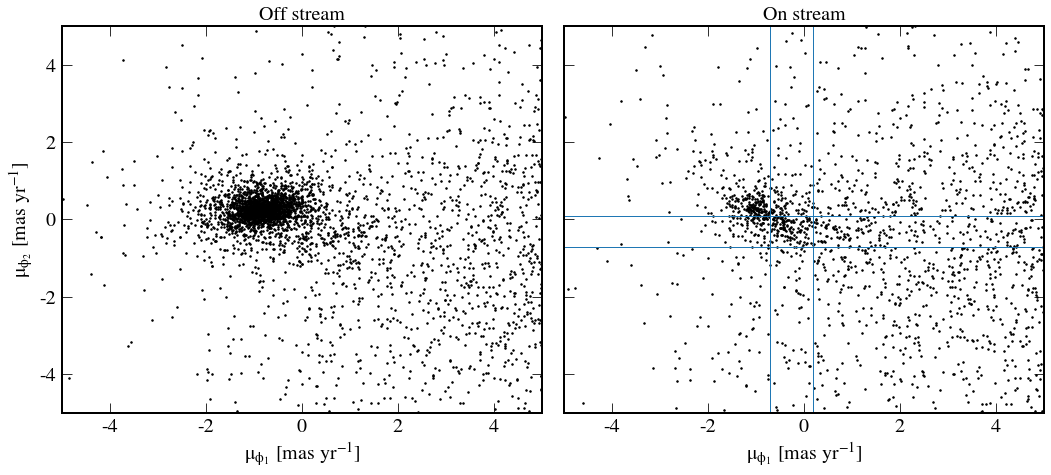

In [39]:
fig, ax = plt.subplots(1,2,figsize=(15,7), sharex=True, sharey=True)

plt.sca(ax[0])
plt.plot(c.pm_phi1_cosphi2[(ind_bhb | ind_cmd) & ind_off], c.pm_phi2[(ind_bhb | ind_cmd) & ind_off],
         'k.', ms=3, alpha=1)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(c.pm_phi1_cosphi2[(ind_bhb | ind_cmd) & ind_phi2], c.pm_phi2[(ind_bhb | ind_cmd) & ind_phi2],
         'k.', ms=3, alpha=1)
# plt.plot(c.pm_phi1_cosphi2[ind_bhb & ind_pmeq], c.pm_phi2[ind_bhb & ind_pmeq], 'ro', ms=1)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.title('On stream', fontsize='medium')

lw = 1
plt.axvline(-0.7, lw=lw)
plt.axvline(0.2, lw=lw)
plt.axhline(-0.7, lw=lw)
plt.axhline(0.1, lw=lw)


plt.tight_layout()

In [40]:
ind_pm = ((c.pm_phi1_cosphi2>-0.7*u.mas/u.yr) & (c.pm_phi1_cosphi2<0.2*u.mas/u.yr) & (c.pm_phi2>-0.7*u.mas/u.yr)
          & (c.pm_phi2<0.1*u.mas/u.yr))

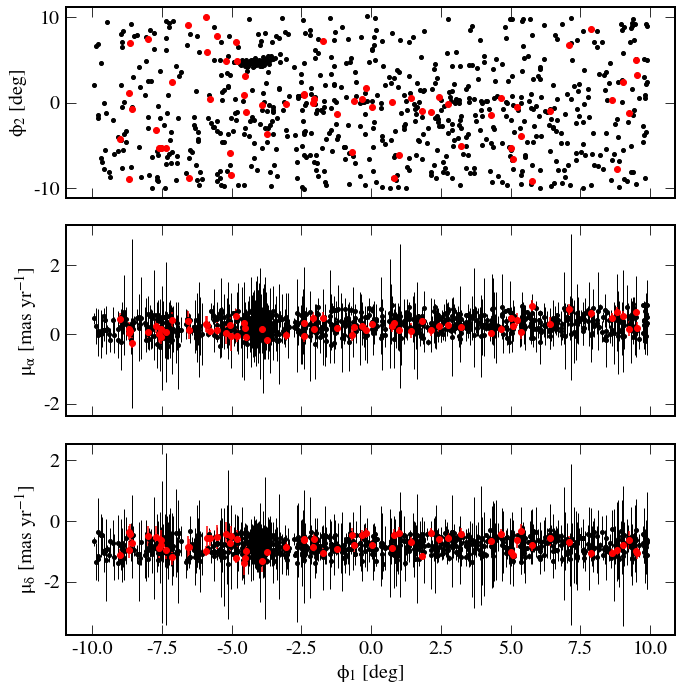

In [41]:
y = [c.phi2.value, t['pmra'], t['pmdec']]
yerr = [(t['dec_error']*u.mas).to(u.deg).value, t['pmra_error'], t['pmdec_error']]
nr = len(y)

ylabels = ['$\phi_2$ [deg]', '$\mu_{\\alpha}$ [mas yr$^{-1}$]', '$\mu_{\delta}$ [mas yr$^{-1}$]']

ind_mem = ind_pm & ind_cmd
ind_mem_bhb = ind_pm & ind_bhb # (np.abs(c.phi2)<2*u.deg)

fig, ax = plt.subplots(nr, 1, figsize=(10,10), sharex=True)

for i in range(nr):
    plt.sca(ax[i])
    plt.errorbar(c.phi1.value[ind_mem], y[i][ind_mem], yerr=yerr[i][ind_mem], fmt='o', ms=4, color='k', lw=1)
    plt.errorbar(c.phi1.value[ind_mem_bhb], y[i][ind_mem_bhb], yerr=yerr[i][ind_mem_bhb], fmt='o', color='r')
    plt.ylabel(ylabels[i])

plt.xlabel('$\phi_1$ [deg]')
    
plt.tight_layout()
plt.savefig('../plots/elqui_track.png')

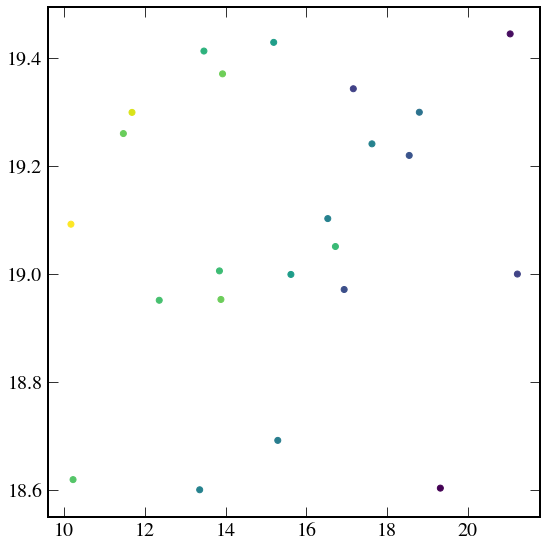

In [52]:
wangle = 180*u.deg
# plt.scatter(ceq_nc.ra.wrap_at(wangle)[ind_mem_bhb], t['phot_g_mean_mag'][ind_mem_bhb],
#             c=ceq_nc.dec[ind_mem_bhb].value)
plt.scatter(ceq_nc.ra[ind_mem_bhb & ind_save], t['phot_g_mean_mag'][ind_mem_bhb & ind_save],
            c=ceq_nc.dec[ind_mem_bhb & ind_save].value)
plt.tight_layout()

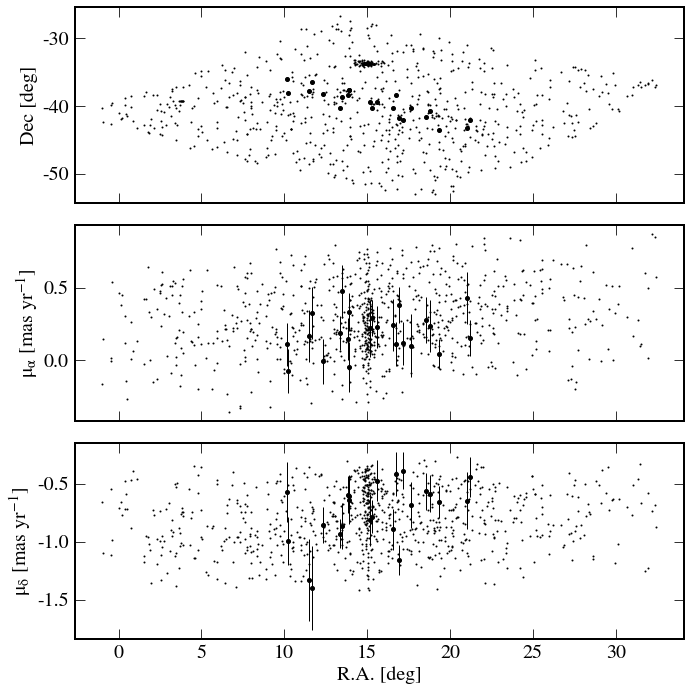

In [48]:
y = [t['dec'], t['pmra'], t['pmdec']]
yerr = [(t['dec_error']*u.mas).to(u.deg).value, t['pmra_error'], t['pmdec_error']]
nr = len(y)
ylabels = ['Dec [deg]', '$\mu_{\\alpha}$ [mas yr$^{-1}$]', '$\mu_{\delta}$ [mas yr$^{-1}$]']

ind_save = (ind_pm & (ind_bhb) & (np.abs(c.phi2.value)<2) #& ~((t['dec']<-60) & (t['phot_g_mean_mag']>18.5))
                    & (c.phi1>-6*u.deg) & (c.phi1<6*u.deg))

fig, ax = plt.subplots(nr, 1, figsize=(10,10), sharex=True)

for i in range(nr):
    plt.sca(ax[i])
    
    plt.plot(ceq_nc.ra.wrap_at(wangle)[ind_mem], y[i][ind_mem], 'ko', ms=1)
    plt.errorbar(ceq_nc.ra.wrap_at(wangle).value[ind_save], y[i][ind_save], yerr=yerr[i][ind_save], 
                 fmt='o', color='k', ms=4, lw=1)

    plt.ylabel(ylabels[i])
    
#     if i==0:
#         plt.gca().set_aspect('equal')

plt.xlabel('R.A. [deg]')

plt.tight_layout()

In [49]:
width = np.std(c.phi2[ind_save])

In [50]:
data = dict()
data['dec'] = [ceq_nc.ra[ind_save], ceq_nc.dec[ind_save], np.ones(np.sum(ind_save))*width, 
               ceq_nc.dec[ind_save]]
data['dist'] = [ceq_nc.ra[ind_save], np.ones(np.sum(ind_save))*distance_app, 
                np.ones(np.sum(ind_save))*delta_distance, ceq_nc.dec[ind_save]]
data['pmra'] = [ceq_nc.ra[ind_save], ceq_nc.pm_ra_cosdec[ind_save], 
                t['pmra_error'][ind_save]*u.mas/u.yr, ceq_nc.dec[ind_save]]
data['pmdec'] = [ceq_nc.ra[ind_save], ceq_nc.pm_dec[ind_save], 
                t['pmdec_error'][ind_save]*u.mas/u.yr, ceq_nc.dec[ind_save]]

In [51]:
pickle.dump(data, open('../data/streams/data_elqui.pkl', 'wb'))
pickle.dump(data, open('../../disrupted_gc/data/streams/data_elqui.pkl', 'wb'))